#  <center>Convex Optimization HW3 

#### <font color='blue'>  Question 1: </font> 

 **Please find the detailed answer in the pdf file**

#### <font color='blue'>  Question 2: Barrier Method implementation </font>

##### a. Implementation of Centering Step

In [716]:
import numpy as np
from numpy import linalg
def log_barrier(A,x,b):
    Ax=np.dot(A,x)
    return np.sum([np.log(b[i]-Ax[i]) for i in range(len(b))])

def objective(Q,p,A,b,t,v):
    return t*np.transpose(v).dot(Q).dot(v) + t*np.transpose(p).dot(v)-log_barrier(A,v,b)


def grad_f(Q,p,A,b,t,v):
    grad= t*(2*np.dot(Q,v) + p)
    for i in range(A.shape[0]):
        grad += (1./(b[i]-np.dot(A,v)[i]))*np.transpose(A)[:,i].reshape((len(v),1))
    return grad

def hess_f(Q,p,A,b,t,v):
    hess = 2*t*Q
    for i in range(A.shape[0]):
        aux = np.zeros((A.shape[0],A.shape[0]), dtype=float)
        aux [i,i] = 1
        hess += (1/(b[i]-np.dot(A,v)[i])**2)*np.transpose(A).dot(aux).dot(A)
    return hess
        
def centering_step(Q,p,A,b,t,v0,eps):
    v_history = [v0]
    alpha = 0.05
    beta = 0.5
    criterion = np.transpose(grad_f(Q,p,A,b,t,v_history[-1])).dot(linalg.inv(hess_f(Q,p,A,b,t,v_history[-1]))).dot(grad_f(Q,p,A,b,t,v_history[-1]))
    while criterion/2. > eps:
        decrement = -linalg.inv(hess_f(Q,p,A,b,t,v_history[-1])).dot(grad_f(Q,p,A,b,t,v_history[-1]))
        step = 1
        v = v_history[-1]+step*decrement
        i=0
        while (i<100) and np.all((b-np.dot(A,v))>0) and (objective(Q,p,A,b,t,v)>= objective(Q,p,A,b,t,v_history[-1]) + alpha*step*np.transpose(grad_f(Q,p,A,b,t,v_history[-1])).dot(decrement)) :
            step = beta*step
            v = v_history[-1]+step*decrement
            i += 1
        v_history.append(v)
        criterion = np.transpose(grad_f(Q,p,A,b,t,v_history[-1])).dot(linalg.inv(hess_f(Q,p,A,b,t,v_history[-1]))).dot(grad_f(Q,p,A,b,t,v_history[-1]))

    return v_history
        
        

##### ** Example on centering step **

In [719]:
n=10
d=100
eps=1e-4
lambd=10

A=np.random.rand(n,n)
Q=0.5*np.eye(n,n)
p=np.ones((n,1))
b=lambd*np.ones((n,1))
v0=np.random.rand(n,1)

t=1
v_history=centering_step(Q,p,A,b,1,v0,eps)
print('Optimal v=')
v_history[-1]

Optimal v=


array([[-1.18697563],
       [-1.29105895],
       [-1.2945631 ],
       [-1.20906039],
       [-1.36524264],
       [-1.3119379 ],
       [-1.36461595],
       [-1.27967131],
       [-1.29818856],
       [-1.30547052]])

##### b. Barrier Method implementation

In [720]:
def barr_method(Q,p,A,b,v0,eps,mu):
    m=len(A)
    t=1   
    centering_results={t:centering_step(Q,p,A,b,t,v0,eps)}
    v_history=[v0,centering_results[t][-1]]
    i=0
    while m/t >= eps :
        t=mu*t
        centering_results[t]=centering_step(Q,p,A,b,t,v_history[-1],eps)
        v_history.append(centering_results[t][-1])
        i+=1
    
    return v_history,centering_results

##### ** Example on barrier method **

In [721]:
mu=15
eps=1e-3
v_history,centering_results=barr_method(Q,p,A,b,v0,eps,mu)

In [722]:
print( 'List of t used = ',t_list)
print('Optimal v =',v_history[-1])
print('Contraint verified on the optimal v?',np.all((b-A.dot(v_history[-1]))>0))

List of t used =  [1, 15, 225, 3375, 50625, 759375]
Optimal v = [[-1.00000408]
 [-1.00000637]
 [-1.00000642]
 [-1.00000458]
 [-1.00000799]
 [-1.00000683]
 [-1.00000798]
 [-1.00000611]
 [-1.00000652]
 [-1.00000667]]
Contraint verified on the optimal v? True


#### <font color='blue'>  Question 3: randomly Generated data testing </font>

##### a. Generate random data

In [878]:
n=10
d=100
eps=1e-6
lambd=10


Q = 0.5*np.eye(n,n)
b = lambd*np.ones((2*d,1))

p=100*np.random.rand(n,1)
X = 100*np.random.rand(10,d)
A = np.concatenate((X.T, -X.T), axis=0)
v0=-np.random.rand(n,1)

mu_list=[2,3,5,15,50,100,200,500]
v_history,centering_results=barr_method(Q,p,A,b,v0,eps,10)
print(v_history[-1])

[[-97.83044502]
 [-44.74238595]
 [-12.55060034]
 [-35.89605482]
 [ -4.89389566]
 [-75.3974282 ]
 [-10.06353049]
 [-63.34909136]
 [-13.63586422]
 [-84.75026257]]


##### b. Plot the Gap:

In [874]:
import matplotlib.pyplot as plt

def plot_gap(Q,p,A,b,v0,eps,mu_list):
    
    f=lambda x: (np.transpose(x).dot(Q).dot(x) + np.transpose(p).dot(x))[0,0] 
    
    for mu in mu_list:
        v_history,centering_results= barr_method(Q,p,A,b,v0,eps,mu)
        gap=np.array([f(v)-f(v_history[-1]) for v in v_history]).reshape(-1,1)
        iterations=list(np.cumsum([len(centering_results[t]) for t in centering_results.keys()]))
        iterations.append(0)
        plt.plot(iterations,gap, label='mu = '+str(mu))
    plt.grid()
    plt.title('Influence of mu')
    plt.semilogy()
    plt.legend()
    plt.xlim(5,100)
    plt.xlabel('number of iterations')
    plt.ylabel('f($v_t$)-$f^*$')
    plt.show() 


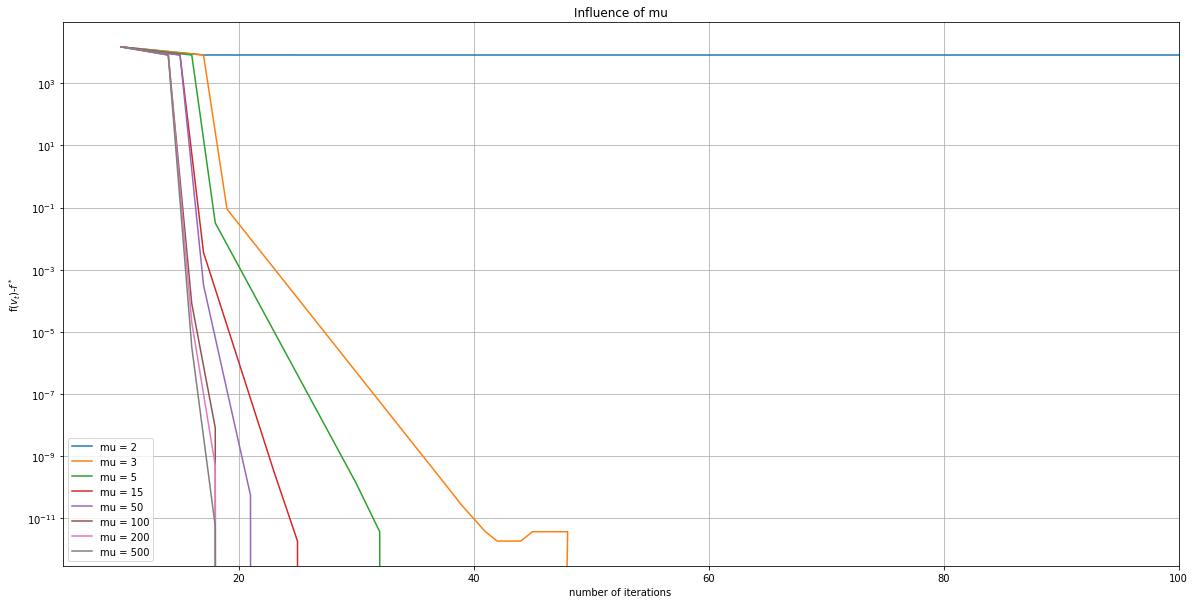

In [876]:
plt.figure(figsize=(20,10)) 
plot_gap(Q,p,A,b,v0,eps,mu_list)

##### c. Influence of mu on w 

In [883]:
y=100*np.random.rand(10,1)
z_list=[]
for mu in mu_list:
    v_history,centering_results=barr_method(Q,p,A,b,v0,eps,mu)
    z_list.append(linalg.norm(y-v_history[-1]))    

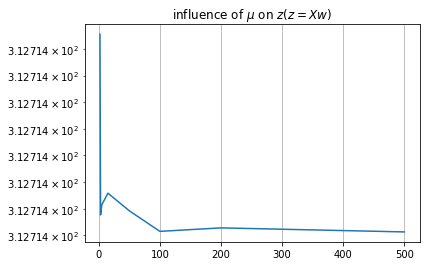

In [886]:
plt.plot(mu_list,z_list)
plt.title('influence of $\mu$ on $z (z=Xw)$')
plt.grid()
plt.semilogy()
plt.show()

##### d. comment

- Best $\mu$ is **>= 50**, as it converges quickly and in  **20 iterations or less.**
- We know that  $z=Xw=y-v$  and that the more mu increases, the larger is the step on minimization which means that convergences is quicker with larger $\mu$ which shown in the graph above.